In [1]:
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

In [3]:
CLOUD_DUMP_PATH = 'data/cloud_dump/'
CLOUD_DUMP_TOUCHED_PATH = 'data/cloud_dump/is_touched_20221006_1815.csv'
ROBOT_DUMP_PATH = 'data/robot_dump/'
CONTENT = 'data/meda_content'

In [4]:
def get_cloud_data(path):
    dfs = []
    json_paths = [path for path in [x for x in os.walk(path)][0][2] if '.json' in path]
    for name in json_paths:
        with open(os.path.join(path, name)) as f:
            dfs.append(pd.read_json(f).set_index('id'))
    return pd.concat(dfs, axis=0)
    
def get_robot_data(path):
    dfs = []
    json_paths = [path for path in [x for x in os.walk(path)][0][2] if '.json' in path]
    for name in json_paths:
        with open(os.path.join(path, name)) as f:
            dfs.append(pd.DataFrame.from_dict(json.load(f)['data']).set_index('id'))
    return pd.concat(dfs, axis=0)

def merge_data(cloud_data, robot_data, columns=['palletPlaceImageUri', 'scanResult', 'location', 'addDate']):
    assert(set(columns).issubset(cloud_data.columns))
    assert(set(columns).issubset(robot_data.columns))
    to_concat = [cloud_data[columns], robot_data[columns]]
    return pd.concat(to_concat, axis=0)

def get_raw_data(cloud_data_path, robot_data_path):
    cloud_data = get_cloud_data(cloud_data_path)
    robot_data = get_robot_data(robot_data_path)
    robot_data.rename(columns={'createdDatetime': 'addDate'}, inplace=True)
    return merge_data(cloud_data, robot_data)

In [5]:
def get_jpeg_paths(content_folder):
    jpeg_paths = {}
    for folder in os.walk(content_folder):
        for path in folder[2]:
            if '.jpeg' in path:
                jpeg_paths[path] = os.path.join(folder[0], path)
    return jpeg_paths

def replace_jpeg_paths(data, jpeg_paths, column='jpeg_path'):
    assert(column in data.columns)
    data[column] = data.apply(lambda x: jpeg_paths[x[column]] if x[column] in jpeg_paths else np.NaN, axis=1)
    return data

def preprocess(raw_data, touched_data, content_folder):
    raw_data.rename(columns={
        'palletPlaceImageUri': 'jpeg_path',
        'scanResult': 'pallet',
    }, inplace=True)
    jpeg_paths = get_jpeg_paths(content_folder)
    data = pd.merge(raw_data, touched_data, how='left',on=['pallet','location'])
    data = replace_jpeg_paths(data, jpeg_paths)
    return data

In [6]:
def print_img(path):
    image = cv2.imread(path)
    plt.imshow(image)
    plt.show()

In [7]:
raw_data = get_raw_data(CLOUD_DUMP_PATH, ROBOT_DUMP_PATH)
touched_data = pd.read_csv(CLOUD_DUMP_TOUCHED_PATH, names=['pallet','location','is_touched'])

In [8]:
data = preprocess(raw_data, touched_data, CONTENT)

# Обучим бейзлайн модель

In [9]:
data = data.dropna()

In [10]:
data['is_touched'] = data['is_touched'].astype(int)

In [11]:
import seaborn as sns

<AxesSubplot: xlabel='is_touched', ylabel='Count'>

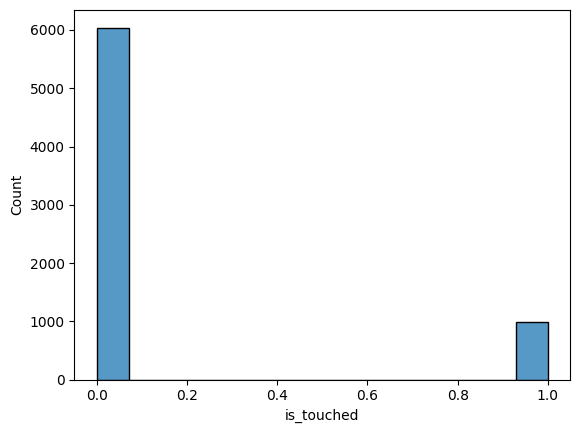

In [12]:
sns.histplot(data['is_touched'])

In [13]:
import torch
torch.cuda.is_available()

True

In [14]:
import pandas as pd
import ipyplot
import torch
import pytorch_lightning as pl
from sklearn.metrics import f1_score, accuracy_score

In [15]:
all_images = list(data['jpeg_path'])

In [16]:
import cv2

all_shapes = []
for img_name in all_images:
    img = cv2.imread(img_name)
    all_shapes.append(img.shape[:2])

In [17]:
# Все изображения одного размера!
np.unique(all_shapes)

array([ 424, 1224])

In [18]:
from torchvision import transforms
import functools
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [   
        transforms.ToTensor(),
        transforms.Resize((608, 208)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

inv_im_trans = transforms.Normalize(
                mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                std=[1/0.229, 1/0.224, 1/0.225])

In [19]:
from torch.utils.data import Dataset
from skimage import io

class ImagesDataset(Dataset):
    def __init__(self, image_paths, labels = None, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.labels = labels
        self.targets = self.labels
        self.transform = transform
        
        if self.labels is not None:
            assert len(self.image_paths) == len(self.labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if self.labels is not None:
            label = self.labels[idx]
        else:
            label = -1 # Carefully handle that!
        img = io.imread(self.image_paths[idx])
        img = img[...,:3] # Some images have 4 channels, fix that
        if self.transform:
            img = self.transform(img)

        return img, label

In [20]:
data = data.sort_values(by=['jpeg_path'])

In [21]:
train_dataset = ImagesDataset(list(data['jpeg_path']), list(data['is_touched']), transform=transform)

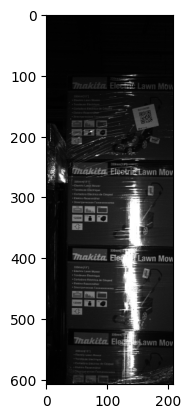

In [22]:
plt.imshow(inv_im_trans(train_dataset[20][0]).permute(1, 2, 0).numpy())

In [23]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# train_indices, val_indices, _, _ = train_test_split(range(len(train_dataset)), train_dataset.targets, 
#                                                     stratify=train_dataset.targets, test_size=0.3, random_state=1337)

# train_split = Subset(train_dataset, train_indices)
# val_split = Subset(train_dataset, val_indices)

In [24]:
pallets = np.unique(data['pallet'])
train_pallets, test_pallets = train_test_split(pallets, test_size=0.2, random_state=42)
data_train, data_test = data.loc[data['pallet'].isin(train_pallets)], data.loc[data['pallet'].isin(test_pallets)]

In [25]:
train_split = ImagesDataset(list(data_train['jpeg_path']), list(data_train['is_touched']), transform=transform)
val_split = ImagesDataset(list(data_test['jpeg_path']), list(data_test['is_touched']), transform=transform)

In [26]:
train_loader = torch.utils.data.DataLoader(train_split, 
                                           batch_size=24,
                                           num_workers=0,
                                           shuffle=True,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(val_split, 
                                         batch_size=24,
                                         num_workers=0,
                                         shuffle=False)

In [27]:
import torch
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch import nn
from torch.nn import *
import pytorch_lightning as pl
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
import timm


class ImageClassifier(pl.LightningModule):
    def __init__(self, trunk=None, class_weight=None, learning_rate=1e-4):
        super().__init__()
        self.class_weight = class_weight
        self.trunk = timm.create_model('resnet50', pretrained=True)
        self.trunk.fc = nn.Linear(2048, 2)
        self.learning_rate =  learning_rate

    def forward(self, x):
        return self.trunk(x)

    def predict_proba(self, x):
        probabilities = nn.functional.softmax(self.forward(x), dim=1)
        return probabilities

    def predict(self, x):
        return torch.max(self.forward(x), 1)[1]

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(),
                                      lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss(weight=self.class_weight)(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss(weight=self.class_weight)(y_hat, y)
        self.log("val_loss", loss)

In [30]:
model = ImageClassifier(learning_rate=1e-4)
trainer = pl.Trainer(
    max_epochs=10,
    log_every_n_steps=-1,
    gpus=-1
)
trainer.fit(model, train_loader, val_loader)
trainer.save_checkpoint("model_timm.ckpt")

Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | trunk | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [29]:
model = ImageClassifier(learning_rate=1e-4)

In [37]:
model.load_state_dict(torch.load('./model_timm.ckpt')['state_dict'])
model.eval()

ImageClassifier(
  (trunk): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05

In [38]:
import tqdm.auto as tqdm

def evaluate_model_val(model, loader):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for x, y in tqdm.tqdm(loader):
            prediction = model.predict(x.to(model.device)).cpu().numpy()
            predictions += list(prediction)
            labels += list(y.numpy())
    return labels, predictions

In [39]:
val_loader = torch.utils.data.DataLoader(val_split, batch_size=32, num_workers=0, shuffle=False)
labels, predictions = evaluate_model_val(model, val_loader)

  0%|          | 0/44 [00:00<?, ?it/s]

In [41]:
print("Dummy Baseline accuracy: ", np.mean(0 == np.array(labels)))
print("Baseline accuracy: ", np.mean(np.array(predictions) == np.array(labels)))

Dummy Baseline accuracy:  0.8603151862464183
Baseline accuracy:  0.8553008595988538


In [42]:
# Shap

In [97]:
torch.manual_seed(0xDEAD)
val_loader = torch.utils.data.DataLoader(val_split, batch_size=128, num_workers=0, shuffle=True)

In [98]:
import shap
batch = next(iter(val_loader))
images, _ = batch

background = images[:120]
test_images = images[120:]

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


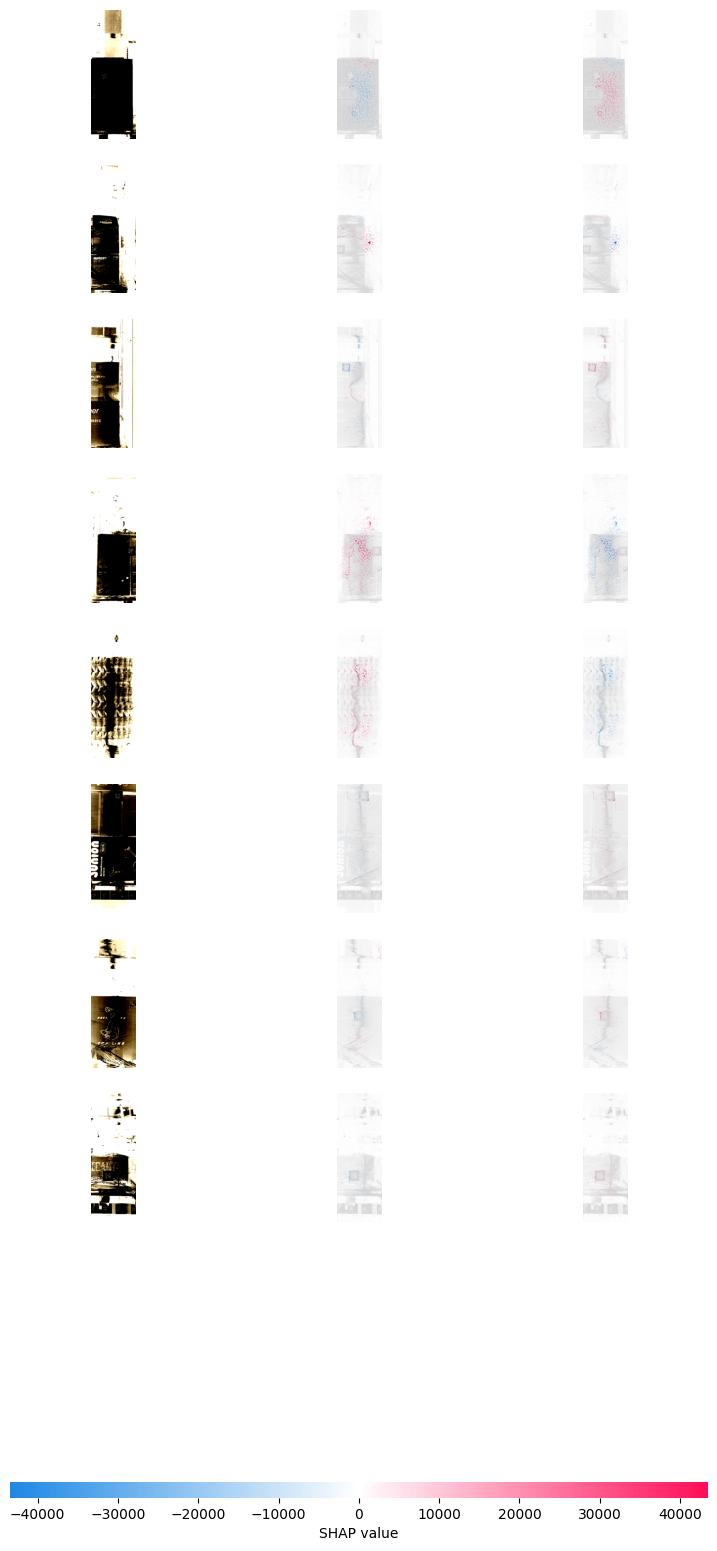

In [99]:
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [118]:
# np.save('shap_numpy.npy', shap_numpy)
# np.save('imgs.npy', batch[0][120:].numpy())

In [148]:
batch[1][120:]

tensor([0, 0, 0, 1, 0, 0, 1, 1])

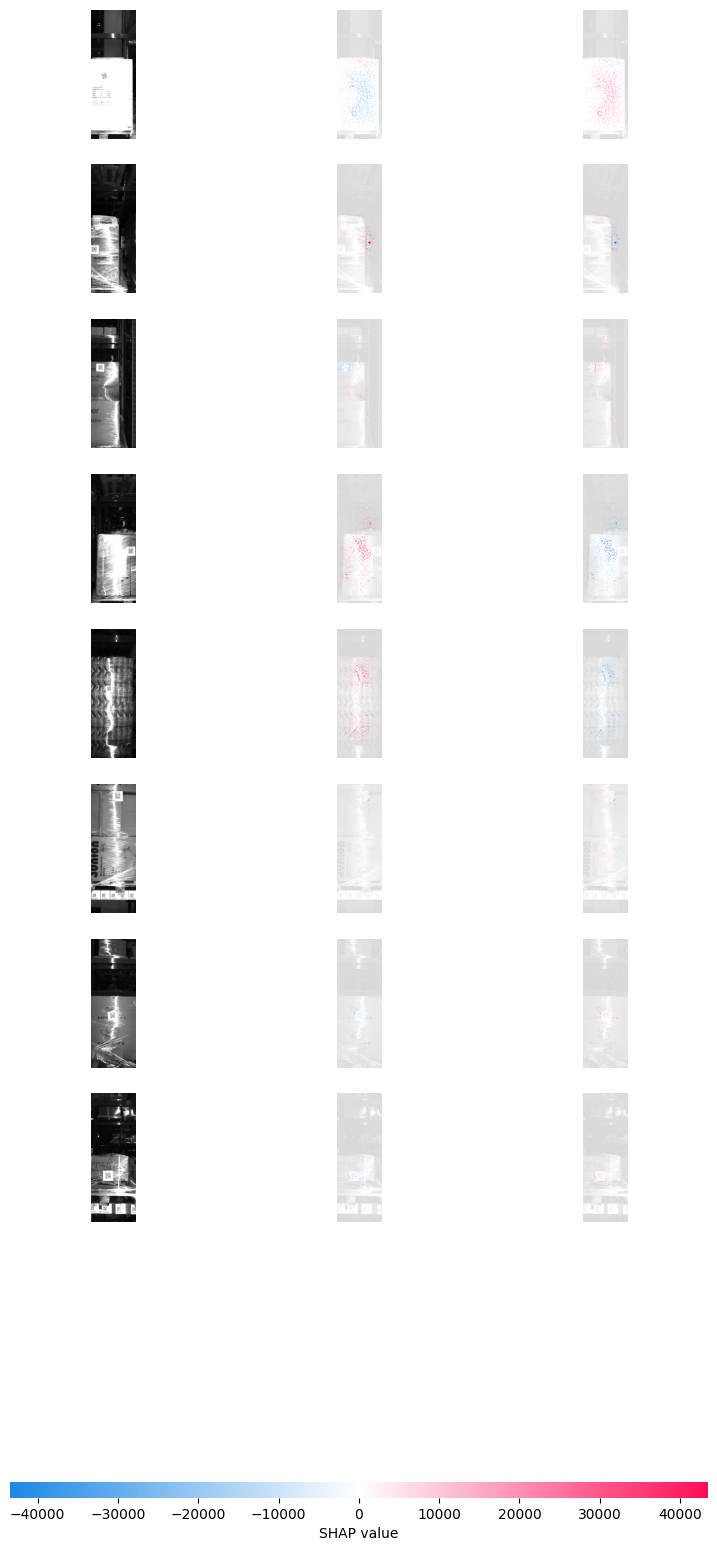

In [146]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(inv_im_trans(test_images).numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy, width=30, show = False)
plt.savefig('./shap.png', dpi=500)